<a href="https://colab.research.google.com/github/pabanib/CEFIM-Informes/blob/main/Acciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de acciones

Con pyhton se puede tener la información de la cotización diaria de acciones de cualquier país. Y no solo la diaria, sino que se puede traer los históricos de cotizaciones lo que permite hacer nuestros propios análisis. Esto se puede hacer con la api de yahoo finance.


In [94]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

Generamos una lista de acciones que queremos observar los históricos, los nombres deben ser los códigos que utilizan los papeles. Si se quiere obtener los de una bolsa específica hay que seguirlos de un punto seguido y la abreviación de la bolsa en la cual queremos la cotización. Por ejemplo para traer las cotizaciones argentinas se debe escribir "GAL.BA", este caso traería la cotización del banco Galicia. En caso que no lleven el punto de la bolsa trae las cotizaciones de EEUU.

In [17]:
Acciones = ['ABNB','GOOGL','IBM','INTC','TSLA','MELI','MSFT', 'AMD','NVDA','DIA','AAPL','GOLD','PYPL','KO','AAL','TUP']

Luego podemos obtener una base de datos con todas las cotizaciones de la lista que queríamos desde alguna fecha deseada.

In [18]:
acciones = {}
errores = []
for i in Acciones:
    try:
      p = yf.Ticker(i).history(start = '2016-01-01')
      acciones[i] = p
    except TypeError:
      errores.append(i)
acciones = pd.concat(acciones)

In [19]:
acciones.loc['NVDA']

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2016-01-04 00:00:00-05:00,0.787906,0.794982,0.781806,0.789858,358076000,0.0,0.0,NaN
2016-01-05 00:00:00-05:00,0.804743,0.815967,0.793030,0.802547,490272000,0.0,0.0,NaN
2016-01-06 00:00:00-05:00,0.789370,0.793030,0.760333,0.769361,449344000,0.0,0.0,NaN
2016-01-07 00:00:00-05:00,0.750085,0.755209,0.729100,0.738860,645304000,0.0,0.0,NaN
2016-01-08 00:00:00-05:00,0.748376,0.749108,0.721535,0.723000,398472000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
2024-09-18 00:00:00-04:00,115.889999,117.699997,113.220001,113.370003,310318900,0.0,0.0,NaN
2024-09-19 00:00:00-04:00,117.349998,119.660004,117.250000,117.870003,293506400,0.0,0.0,NaN
2024-09-20 00:00:00-04:00,117.059998,118.620003,115.389999,116.000000,382462400,0.0,0.0,NaN


Graficamos todas las acciones listadas para ver la evolución que tuvieron en el periodo elegido.

In [140]:
acci = acciones.Close.unstack(0)
acci = acci/acci.loc['2024-01-03']
px.line(acci.loc['2016-01-01':])

In [22]:
(acci.iloc[-1]-1).sort_values()

,2024-09-24 00:00:00-04:00
INTC,-0.542942
TUP,-0.473293
AAL,-0.212934
ABNB,-0.130220
TSLA,-0.093576
AMD,0.129358
MSFT,0.129595
DIA,0.138219
AAPL,0.168107
GOLD,0.171650


# Portafolio

Para trabajar un portafolio de acciones creamos una clase llamada portafolio que realiza todas las acciones necesarias para los movimientos. De esta manera podemos tener un control, con información actualizada e histórica de nuestras inversiones.

In [23]:
class portafolio():
  def __init__(self, plata = 0):
    self.plata = plata
    self.acciones = {}
    self.movimientos = pd.DataFrame()
    self.num_mov = 0
    self.mov_plata = pd.DataFrame()
    self.num_mov_plata = 0

  def ing_dinero(self, monto, fecha):
    self.plata += monto
    print(f'Ingreso {monto} dólares')
    self.num_mov_plata += 1
    self.mov_plata = pd.concat([self.mov_plata, pd.DataFrame({'fecha': fecha, 'monto': monto}, index = [self.num_mov_plata])])


  def ret_dinero(self, monto, fecha):
    if monto > self.plata:
      print('No tienes suficiente dinero')
    else:
      self.plata -= monto
      print(f'Retiro {monto} dólares')
      self.num_mov_plata += 1
      self.mov_plata = pd.concat([self.mov_plata, pd.DataFrame({'fecha': fecha, 'monto': monto*-1}, index = [self.num_mov_plata])])

  def comprar_accion(self, ticker, cantidad, fecha ):
    precio = acciones.loc[ticker].loc[fecha].Open
    monto = cantidad * precio
    if monto > self.plata:
      print('No tienes suficiente dinero')
    else:
      self.plata -= monto
      if ticker in self.acciones.keys():
        self.acciones[ticker] += cantidad
      else:
        self.acciones[ticker] = cantidad
      self.mov_historicos(ticker, cantidad, fecha)


  def vender_accion(self, ticker, cantidad, fecha):
    precio = acciones.loc[ticker].loc[fecha].Open
    monto = cantidad * precio
    self.plata += monto
    self.acciones[ticker] -= cantidad
    self.mov_historicos(ticker, cantidad*-1, fecha)
    if self.acciones[ticker] == 0:
      del self.acciones[ticker]

  def mov_historicos(self, ticker, cantidad, fecha):
    precio = acciones.loc[ticker].loc[fecha].Open
    monto = cantidad * precio
    dic = {'ticker': ticker, 'cantidad': cantidad, 'fecha': fecha, 'precio': precio, 'monto': monto}
    self.num_mov += 1
    self.movimientos = pd.concat([self.movimientos, pd.DataFrame(dic, index = [self.num_mov])])

  def balance(self, fecha):
    df = self.movimientos.groupby('ticker').agg({'cantidad': 'sum','precio': 'mean' ,'monto': 'sum'})

    for k in self.acciones.keys():
      precio_actual = acciones.loc[k].iloc[-1].Close
      df.loc[k, 'Precio Actual'] = precio_actual
      df.loc[k, 'Valor Actual'] = df.loc[k, 'cantidad'] * precio_actual
      df.loc[k, 'Rendimiento'] = np.round((df.loc[k, 'Precio Actual'] - df.loc[k, 'precio']) / df.loc[k, 'precio']*100,2)
      df.loc[k, 'Ganancia'] = np.round(df.loc[k, 'Valor Actual'] - df.loc[k, 'monto'],2)

    self.posiciones = df
    return df


Abrimos un portafolio y le ingresamos dinero. Luego se procede a realizar las primeras compras de acciones

In [24]:
porta = portafolio()
porta.ing_dinero(120000, '2021-05-02')
porta.comprar_accion('PYPL', 80,'2021-05-14')
porta.comprar_accion('GOOGL', 350,'2021-03-10')
porta.comprar_accion('AAL', 150,'2022-01-25')



Ingreso 120000 dólares


Podemos consultar los movimientos que fuimos realizando, el precio que se compró y el monto

In [25]:
porta.movimientos

,ticker,cantidad,fecha,precio,monto
1,PYPL,80,2021-05-14,244.018997,19521.519775
2,GOOGL,350,2021-03-10,102.815406,35985.392111
3,AAL,150,2022-01-25,16.049999,2407.499886


Realizamos unas compras más y ventas

In [26]:
porta.vender_accion('GOOGL', 100, '2023-05-16')
porta.comprar_accion('KO', 230, '2023-05-26')
porta.comprar_accion('NVDA', 300, '2023-06-06')
porta.movimientos

,ticker,cantidad,fecha,precio,monto
1,PYPL,80,2021-05-14,244.018997,19521.519775
2,GOOGL,350,2021-03-10,102.815406,35985.392111
3,AAL,150,2022-01-25,16.049999,2407.499886
4,GOOGL,-100,2023-05-16,116.202261,-11620.226091
5,KO,230,2023-05-26,57.735226,13279.102039
6,NVDA,300,2023-06-06,38.811045,11643.313379


A continuación se muestra un gráfico con la evolución de una acción elegida y su media móvil a 30 días. Además si se ha operado con esa acción de acuerdo al portafolio se pueden ver los momentos de compra y de ventas que se realizaron.

In [148]:
tick = 'GOOGL'
quer = "ticker == '"+tick+"'"
df = porta.movimientos.query(quer)
comp = df[df.cantidad > 0]
vent = df[df.cantidad < 0]

fech = '2020-01-01'
pap = tick
pap = pap.upper()

val = pap


df = acciones.loc[val].loc[fech:]
df['mm'] = acciones.loc[val].loc[fech:].Close.rolling(30).mean()

fig = px.line(df, y = ['Close','mm'])

fig.add_trace(go.Scatter(x = comp['fecha'], y= comp['precio'], mode='markers', marker=dict(color='red', size = 15)))
fig.add_trace(go.Scatter(x = vent['fecha'], y= vent['precio'], mode='markers', marker=dict(color='Green', size = 15)))


fig.show()


Luego calculamos los rendimientos que han tenido las compras que hemos realizado

In [27]:
porta.balance('2024-09-24')

,cantidad,precio,monto,Precio Actual,Valor Actual,Rendimiento,Ganancia
ticker,,,,,,,
AAL,150,16.049999,2407.499886,11.040000,1655.999994,-31.21,-751.50
GOOGL,250,109.508833,24365.166019,162.289993,40572.498322,48.20,16207.33
KO,230,57.735226,13279.102039,71.330002,16405.900421,23.55,3126.80
NVDA,300,38.811045,11643.313379,120.870003,36261.000824,211.43,24617.69
PYPL,80,244.018997,19521.519775,78.339996,6267.199707,-67.90,-13254.32


Se puede consultar de manera gráfica como quedan las posiciones de todos las acciones que tenemos.

<Axes: ylabel='Valor Actual'>

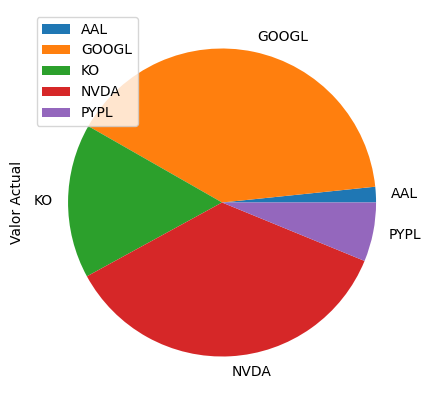

In [28]:
porta.posiciones.plot(kind = 'pie', y = 'Valor Actual', figsize = (5,5))

O se puede analizar el rendimiento obtenido en cada una de las inversiones realizadas.

<Axes: xlabel='ticker'>

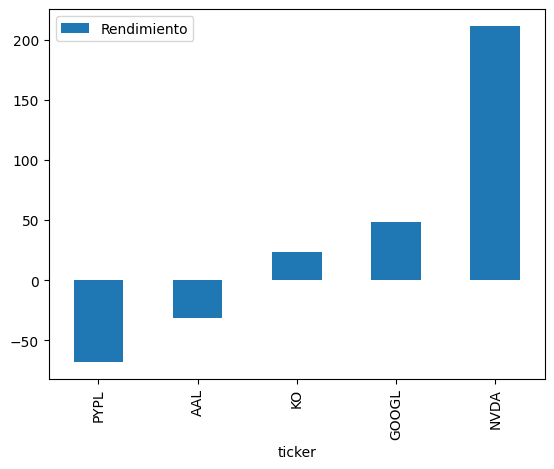

In [29]:
porta.posiciones.sort_values('Rendimiento').plot(kind = 'bar', y = 'Rendimiento')

# Predicción

Para realizar una predicción vamos a utilizar un modelo de alta dimensión pero disperso. Por eso se utiliza como metodología Lasso para que nos permita seleccionar las variables y rezagos necesarios para la mejor predicción.

Se utilizan como variables, los precios de apertura y cierre del día. Los valores altos y los bajos. El volúmen y por último se agrega la diferencia porcentual entre el valor más alto y el más bajo por cada día. Se toman como posible cantidad de rezagos hasta 30 periodos anteriores.

In [131]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.model_selection import GridSearchCV

class predice():
  def __init__(self, ticker):
    self.ticker = ticker

  def gen_lags(self,var, ini = 1, fin = 30, nom = ''):
    X = []
    nombres = []
    for i in range(ini,fin):
      v = var.shift(i)
      X.append(v)
      nombres.append(nom+'lag'+str(i))

    X = pd.concat(X, axis = 1)
    X.columns = nombres
    return X

  def aplicar_col(self,df, nom,*args,**kwargs):
    dfs = []
    for c in df.columns:
      d = gen_lags(df[c],nom = nom+'_'+c+'_', *args, **kwargs )
      dfs.append(d)
    return pd.concat(dfs, axis = 1)

  def prepara_datos(self):
    ticker = self.ticker
    acc = acciones.loc[ticker]
    acc.drop(columns = ['Dividends','Stock Splits','Capital Gains'], inplace = True)
    acc = np.log(acc)
    acc['Var diaria'] = acc.High/acc.Low-1
    self.acc = acc
    self.y = acc.Close
    self.X = self.aplicar_col(acc,ini = 1, fin = 30, nom = ticker)
    self.X = self.X.dropna()
    self.y = self.y[self.X.index[0]:]

    return self.X, self.y

  def entrenamiento(self):
    self.prepara_datos()
    porc_ent = 0.9
    ind = int(len(self.X)*porc_ent)

    self.X_train = self.X.iloc[:ind]
    self.y_train = self.y.iloc[:ind]
    self.X_test = self.X.iloc[ind:]
    self.y_test = self.y.iloc[ind:]
    self.tss = TimeSeriesSplit(n_splits = 5)
    self.params = {'alpha': np.logspace(-3,2,10)}
    self.lasso_grid = GridSearchCV(Lasso(max_iter = 10000), param_grid = self.params, cv = self.tss)
    self.lasso_grid.fit(self.X_train, self.y_train)
    #predicción
    df = pd.DataFrame(self.lasso_grid.best_estimator_.predict(self.X_test), columns = ['predic'])
    df['real'] = self.y_test.values
    return np.exp(df)

  def prediccion(self):
    X_ =  self.aplicar_col(self.acc,ini = 0, fin = 29, nom = self.ticker)
    X_.columns = self.X.columns
    val_fut = np.exp(self.lasso_grid.best_estimator_.predict(pd.DataFrame(X_.iloc[-1]).T))[0]
    val_hoy = np.exp(self.y.iloc[-1])
    return pd.DataFrame([val_hoy,val_fut,(val_fut/val_hoy-1)*100], index = ['val_hoy','val_fut','variación'])

In [135]:
pred = predice('GOOGL')
df = pred.entrenamiento()
df

,predic,real
0,131.229866,131.763718
1,131.385516,133.289948
2,133.310197,134.287476
3,133.781901,136.591782
4,135.618204,134.975769
...,...,...
212,158.709221,159.809998
213,158.975121,162.139999
214,161.552552,163.589996
215,162.543977,161.850006


In [136]:
px.line(df)

In [137]:
pred.prediccion()

,0
val_hoy,162.289993
val_fut,161.460057
variación,-0.511391


# Predicción del portafolio

In [139]:
valores = pd.DataFrame()
for k in porta.acciones.keys():
  pred = predice(k)
  df = pred.entrenamiento()
  val = pred.prediccion()
  valores = pd.concat([valores, val], axis = 1)

valores.columns = porta.acciones.keys()
valores



,PYPL,GOOGL,AAL,KO,NVDA
val_hoy,78.339996,162.289993,11.040000,71.330002,120.870003
val_fut,78.410226,161.460057,11.120746,70.405672,119.387019
variación,0.089648,-0.511391,0.731397,-1.295850,-1.226925
